Задание 5: Сравнение методов отбора признаков. Используйте один и тот же набор данных для применения различных методов отбора признаков, включая корреляционные методы, и сравните результаты.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr

# Загружаем данные
data = load_diabetes()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['TARGET'] = data.target  # Целевая переменная (регрессия)

# Разделяем на признаки и целевую переменную
X = df.drop(columns=['TARGET'])
y = df['TARGET']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Разделяем train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Корреляция Спирмена: Оценивает связь между признаками и целевой переменной, основываясь на ранговой корреляции(присваивая ранги признакам).

In [4]:
# применяем корр. Спирмена
spearman_corr = pd.Series([spearmanr(X[col], y)[0] for col in X.columns], index=X.columns)
spearman_selected_features = spearman_corr.abs().sort_values(ascending=False).index[:5].tolist()

X_train_spearman = X_train[spearman_selected_features]
X_test_spearman = X_test[spearman_selected_features]

# Применяем линейную регрессию для обучения
model = LinearRegression()
model.fit(X_train_spearman, y_train)
y_pred_spearman = model.predict(X_test_spearman)
mse_spearman = mean_squared_error(y_test, y_pred_spearman)

print(f"Spearman MSE: {mse_spearman:.2f}")

Spearman MSE: 2936.48


Recursive Feature Elimination: итеративно удаляет наименее важные признаки, оставляя только самые значимые.

In [24]:
# применяем линейную регрессию и затем RFE
rfe_model = LinearRegression()
rfe = RFE(rfe_model, n_features_to_select=5)
rfe.fit(X_train, y_train)
rfe_selected_features = X.columns[rfe.support_].tolist()

X_train_rfe = X_train[rfe_selected_features]
X_test_rfe = X_test[rfe_selected_features]

model.fit(X_train_rfe, y_train)
y_pred_rfe = model.predict(X_test_rfe)
mse_rfe = mean_squared_error(y_test, y_pred_rfe)

print(f"RFE MSE: {mse_rfe:.2f}")

RFE MSE: 2976.49


Lasso (L1-регуляризация): обнуляет коэффициенты у незначимых признаков, помогая автоматически отбирать самые важные

In [8]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_selected_features = X.columns[np.argsort(np.abs(lasso.coef_))[-5:]].tolist()

X_train_lasso = X_train[lasso_selected_features]
X_test_lasso = X_test[lasso_selected_features]

model.fit(X_train_lasso, y_train)
y_pred_lasso = model.predict(X_test_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

print(f"Lasso MSE: {mse_lasso:.2f}")

Lasso MSE: 2976.49


Случайный лес: анализирует, какие признаки используются для уменьшения неопределенности на более высоких уровнях дерева (например, в корне или в верхних уровнях).

In [10]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
rf_selected_features = rf_feature_importance.sort_values(ascending=False).index[:5].tolist()

X_train_rf = X_train[rf_selected_features]
X_test_rf = X_test[rf_selected_features]

model.fit(X_train_rf, y_train)
y_pred_rf = model.predict(X_test_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf:.2f}")

Random Forest MSE: 2874.54


Метод главных компонент PCA: отбирает компоненты, которые максимально сохраняют информацию при уменьшении объема данных

In [12]:
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

explained_variance = np.sum(pca.explained_variance_ratio_)

print(f"PCA Explained Variance: {explained_variance:.2f}")

PCA Explained Variance: 0.84


Визуализация всех методов

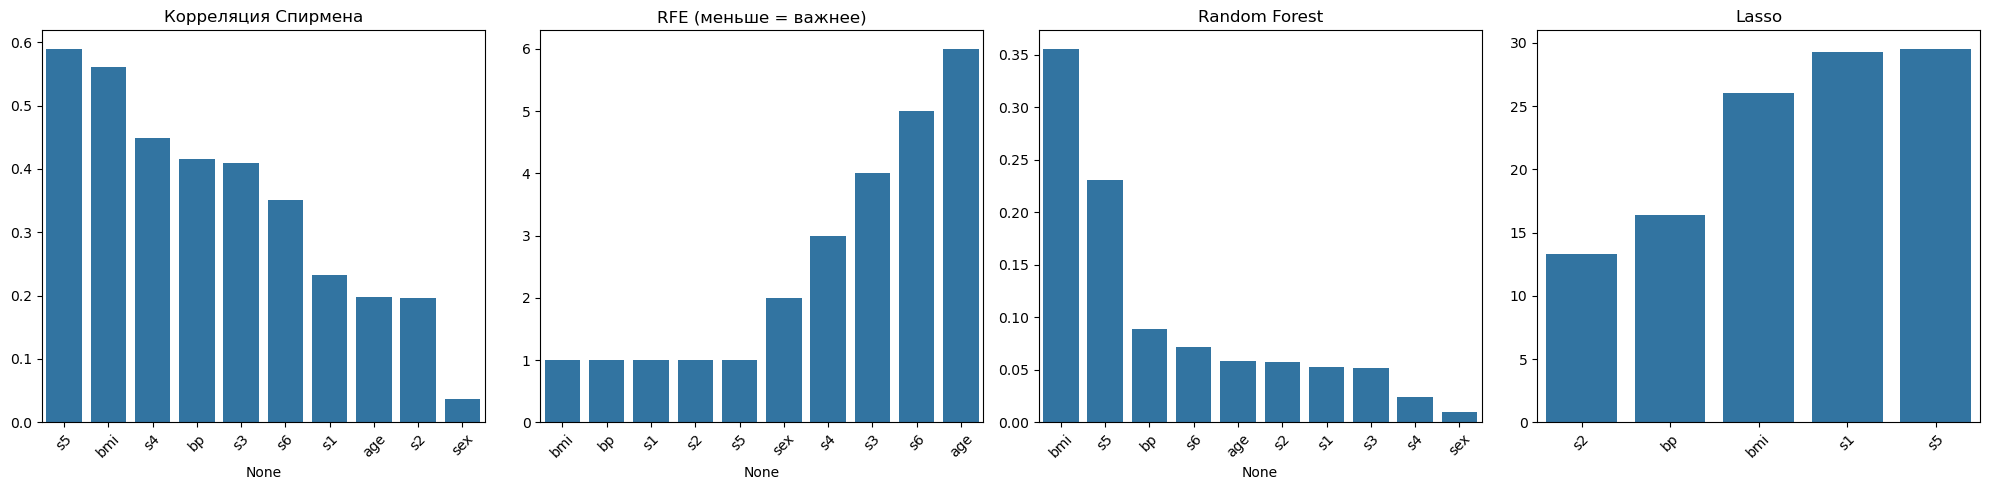

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Spearman
sns.barplot(x=spearman_corr.abs().sort_values(ascending=False)[:10].index,
            y=spearman_corr.abs().sort_values(ascending=False)[:10].values, ax=axes[0])
axes[0].set_title("Корреляция Спирмена")
axes[0].tick_params(axis='x', rotation=45)

# RFE
rfe_ranks = pd.Series(rfe.ranking_, index=X.columns)
sns.barplot(x=rfe_ranks.sort_values()[:10].index, y=rfe_ranks.sort_values()[:10].values, ax=axes[1])
axes[1].set_title("RFE (меньше = важнее)")
axes[1].tick_params(axis='x', rotation=45)

# Random Forest
sns.barplot(x=rf_feature_importance.sort_values(ascending=False)[:10].index,
            y=rf_feature_importance.sort_values(ascending=False)[:10].values, ax=axes[2])
axes[2].set_title("Random Forest")
axes[2].tick_params(axis='x', rotation=45)

# Lasso
sns.barplot(x=lasso_selected_features, 
            y=np.abs(lasso.coef_[[X.columns.get_loc(col) for col in lasso_selected_features]]), ax=axes[3])
axes[3].set_title("Lasso")
axes[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
